CarND-Behavioral-Cloning-P3

In [3]:
#Importing Dependencies when required

import os
import csv

samples=[]
with open('./data/driving_log.csv') as csvfile:
    has_header = csv.Sniffer().has_header(csvfile.read(1024))
    csvfile.seek(0)  # Rewind.
    reader=csv.reader(csvfile)
    if has_header:
        next(reader)  # Skip header row.
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(samples, test_size=0.21)

#Quick Visualization of what we did above
print("Length of Training Data: ",len(train_samples))
print("Random datapoint - ",train_samples[9])
print("Length of Validation Data: ",len(validation_samples))
print("Random datapoint - ",validation_samples[9])

Length of Training Data:  6348
Random datapoint -  ['IMG/center_2016_12_01_13_36_11_709.jpg', ' IMG/left_2016_12_01_13_36_11_709.jpg', ' IMG/right_2016_12_01_13_36_11_709.jpg', ' 0.2148564', ' 0.9855326', ' 0', ' 30.17778']
Length of Validation Data:  1688
Random datapoint -  ['IMG/center_2016_12_01_13_35_54_491.jpg', ' IMG/left_2016_12_01_13_35_54_491.jpg', ' IMG/right_2016_12_01_13_35_54_491.jpg', ' 0', ' 0.9855326', ' 0', ' 30.18668']


Using TensorFlow backend.


Epoch 1/5
38088/38088 [==============================] - 66s - loss: 0.1487 - val_loss: 0.0543
Epoch 2/5
38088/38088 [==============================] - 63s - loss: 0.0406 - val_loss: 0.0305
Epoch 3/5
38088/38088 [==============================] - 63s - loss: 0.0317 - val_loss: 0.0337
Epoch 4/5
38088/38088 [==============================] - 63s - loss: 0.0294 - val_loss: 0.0267
Epoch 5/5
38088/38088 [==============================] - 63s - loss: 0.0285 - val_loss: 0.0282
dict_keys(['loss', 'val_loss'])


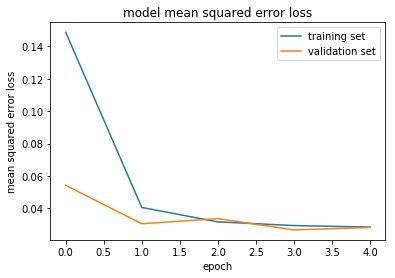

In [4]:
#Using the example Generator from Classroom

import cv2
import numpy as np
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from scipy.misc import toimage
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout, ELU, MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.regularizers import l2
from keras.optimizers import Adam

def generator(samples, batch_size=33):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+(batch_size)]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                name = './data/IMG/'+batch_sample[1].split('/')[-1]
                left_image = cv2.imread(name)
                left_angle = float(batch_sample[3])+0.25
                name = './data/IMG/'+batch_sample[2].split('/')[-1]
                right_image = cv2.imread(name)
                right_angle = float(batch_sample[3])-0.25
                images.append(center_image)
                angles.append(center_angle)
                images.append(left_image)
                angles.append(left_angle)
                images.append(right_image)
                angles.append(right_angle)
            
            #Augment Data by flipping
            augmented_images, augmented_measurements = [] , []
            for image,measurement in zip(images, angles):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*-1.0)
            
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)
            
            yield shuffle(X_train, y_train)


# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=33)
validation_generator = generator(validation_samples, batch_size=33)

#ch, row, col = 3, 160, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
#model.add(Lambda(lambda x: x/127.5 - 1.))
#model.add(... finish defining the rest of your model architecture here ...)

model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3), output_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu",W_regularizer=l2(0.001)))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu",W_regularizer=l2(0.001)))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu",W_regularizer=l2(0.001)))
model.add(Convolution2D(64,3,3,activation="relu",W_regularizer=l2(0.001)))
#model.add(MaxPooling2D((1,1)))
model.add(Convolution2D(64,3,3,activation="relu",W_regularizer=l2(0.001)))
model.add(Flatten())
model.add(Dense(100,W_regularizer=l2(0.001)))
#model.add(Dropout(.6))
#model.add(ELU())
model.add(Dense(50,W_regularizer=l2(0.001)))
model.add(Dense(10,W_regularizer=l2(0.001)))
model.add(Dense(1))

#Adam(lr=1e-4)
model.compile(loss='mse', optimizer='adam')
history_object=model.fit_generator(train_generator, samples_per_epoch= len(train_samples)*6, validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5)

model.save('model.h5')

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()